# **RNN(Recurrent Neural Network) 구현하기**

간단한 시계열 데이터를 사용하여 순환 신경망(RNN)을 구현하고, 시간 변화에 따른 패턴을 분석해 보자.



**데이터 로드 및 시각화**

먼저, 통계분석을 위한 라이브러리인 statsmodels로부터 데이터를 불러온다.

사용할 데이터는 1974-1979년 사이 영국의 호흡기 질환 사망자 수를 나타내는 
데이터로,

총 72개의 time(연도)과 value(사망자)로 이루어진 2차원 데이터이다.

데이터의 마지막 n개에 해당하는 데이터를 출력하는 tail 함수를 통해 데이터를 확인해본다.

비슷한 함수로 첫 n개를 출력하는 head 함수가 있으며, 데이터를 쉽고 간단하게 확인하는 방법으로 사용된다.

RNN이 학습을 통해 원래 데이터의 분포를 잘 예측하는지 알아보기 위해 clip 함수로 2000 이상의 값들을 모두 2000으로 바꾼다.



/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


           time  value
67  1979.583333   1354
68  1979.666667   1333
69  1979.750000   1492
70  1979.833333   1781
71  1979.916667   1915


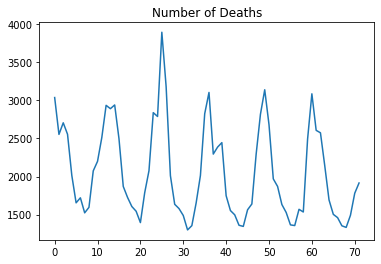

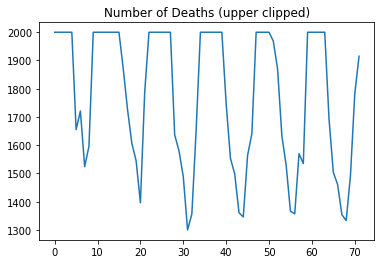

In [1]:
# Import tensorflow packages
import tensorflow as tf
import numpy as np
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pylab as plt
import pandas as pd

data = sm.datasets.get_rdataset("deaths", "MASS")
df = data.data
print(df.tail()) # tail함수로 데이터 끝 n개의 데이터 확인

# 데이터 시각화, upper clipping
df.value.plot()
plt.title("Number of Deaths")
plt.show()

df["cliped_value"] = df.value.clip(upper = 2000)     # Upper clipping
df.cliped_value.plot()
plt.title("Number of Deaths (upper clipped)")
plt.show()

**데이터 표준화 및 시퀀스 데이터셋 생성**

데이터의 값이 너무 큰 값을 가지기 때문에 작은 범위 내의 값을 갖도록 바꿔 주어야 한다.

정규화는 0~1 사이의 값을 갖도록 하며, 표준화는 평균이 0이고 표준편차가 1이 되도록 한다.

학습을 위한 시퀀스 데이터는 처음 7개의 value, 목표값은 8번째 값을 주는 방식으로 생성한다.

이로써 7개의 연속된 값을 통해 다음 값을 예측하도록 하는 학습 데이터를 구성할 수 있다.

In [2]:
ts = 7      # time steps

# 입력 데이터의 표준화
df["cliped_std_value"] = df.cliped_value.map(lambda x : (x - df.cliped_value.mean()) / np.std(df.cliped_value))
print(df["cliped_std_value"])

# 학습을 위한 시퀀스 데이터셋 생성 (7 inputs, 1 outputs) 
X_train = np.asarray([np.array([df.cliped_std_value.values[i + j] for j in range(ts)])
                      for i in range(len(df.cliped_std_value) - ts)]).reshape(-1, ts, 1)
y_train = df.cliped_std_value.values[ts:]
print(X_train.shape)
print(y_train.shape)
print(X_train)
print(y_train)

0     0.932840
1     0.932840
2     0.932840
3     0.932840
4     0.932840
        ...   
67   -1.698985
68   -1.784540
69   -1.136768
70    0.040627
71    0.586548
Name: cliped_std_value, Length: 72, dtype: float64
(65, 7, 1)
(65,)
[[[ 0.93284047]
  [ 0.93284047]
  [ 0.93284047]
  [ 0.93284047]
  [ 0.93284047]
  [-0.47270104]
  [-0.20381484]]

 [[ 0.93284047]
  [ 0.93284047]
  [ 0.93284047]
  [ 0.93284047]
  [-0.47270104]
  [-0.20381484]
  [-1.00639941]]

 [[ 0.93284047]
  [ 0.93284047]
  [ 0.93284047]
  [-0.47270104]
  [-0.20381484]
  [-1.00639941]
  [-0.71306901]]

 [[ 0.93284047]
  [ 0.93284047]
  [-0.47270104]
  [-0.20381484]
  [-1.00639941]
  [-0.71306901]
  [ 0.93284047]]

 [[ 0.93284047]
  [-0.47270104]
  [-0.20381484]
  [-1.00639941]
  [-0.71306901]
  [ 0.93284047]
  [ 0.93284047]]

 [[-0.47270104]
  [-0.20381484]
  [-1.00639941]
  [-0.71306901]
  [ 0.93284047]
  [ 0.93284047]
  [ 0.93284047]]

 [[-0.20381484]
  [-1.00639941]
  [-0.71306901]
  [ 0.93284047]
  [ 0.93284047]
  [

**순환 신경망 모델 생성**

SimpleRNN을 통해 간단한 순환 신경망을 구성한다. 

MLP, CNN과 마찬가지로 파라미터로 레이어의 노드 개수 및 활성화 함수 등을 설정할 수 있다. 

In [3]:
#from tensorflow.keras import layers
model = tf.keras.Sequential()
model.add(tf.keras.layers.SimpleRNN(100, input_shape = (ts,1)))
#model.add(tf.keras.layers.LSTM(100, input_shape = (ts,1)))

# Add a Dense layer with 1 units.
model.add(tf.keras.layers.Dense(1, activation = 'linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 100)               10200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


**학습 전략 설정 및 모델 학습**

최적화 알고리즘, 손실함수 등을 설정하여 모델을 학습한다. 

In [5]:
import time

model.compile(optimizer = 'sgd',loss = 'mse')
start_time = time.time()
model.fit(X_train, y_train, epochs = 50) # Start training
print("모델 학습 완료. 학습 시간 : {}\n".format(time.time() - start_time))

Epoch 1/50
3/3 [==============================] - 2s 39ms/step - loss: 0.2500
Epoch 2/50
3/3 [==============================] - 0s 23ms/step - loss: 0.2236
Epoch 3/50
3/3 [==============================] - 0s 18ms/step - loss: 0.2756
Epoch 4/50
3/3 [==============================] - 0s 36ms/step - loss: 0.2306
Epoch 5/50
3/3 [==============================] - 0s 19ms/step - loss: 0.2290
Epoch 6/50
3/3 [==============================] - 0s 24ms/step - loss: 0.2442
Epoch 7/50
3/3 [==============================] - 0s 28ms/step - loss: 0.2623
Epoch 8/50
3/3 [==============================] - 0s 22ms/step - loss: 0.2301
Epoch 9/50
3/3 [==============================] - 0s 22ms/step - loss: 0.2264
Epoch 10/50
3/3 [==============================] - 0s 24ms/step - loss: 0.2141
Epoch 11/50
3/3 [==============================] - 0s 22ms/step - loss: 0.2136
Epoch 12/50
3/3 [==============================] - 0s 25ms/step - loss: 0.2104
Epoch 13/50
3/3 [==============================] - 0s 28ms/st

**학습 데이터를 통한 예측**

학습된 RNN모델에 데이터를 입력하여 예측값을 얻고 그래프를 그려 본다.

그래프를 보아 2000으로 upper bounding된 데이터를 가지고도 원래 데이터의 분포를 어느 정도 예측 가능함을 알 수 있다.

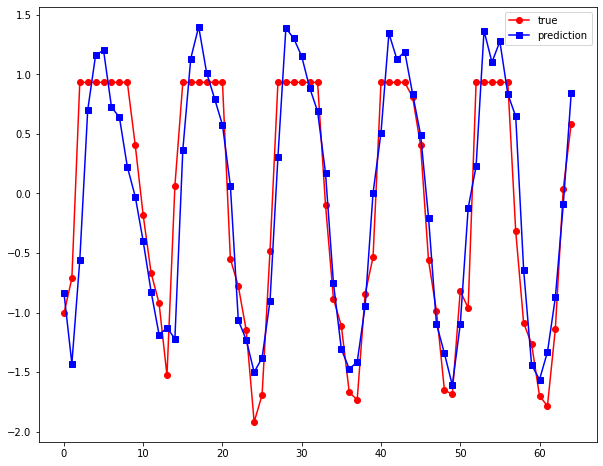

In [6]:
plt.figure(figsize = (10,8))
plt.plot(y_train[:],'ro-',label="true")
plt.plot(model.predict(X_train[:,:,:]),'bs-',label="prediction")
plt.legend()
plt.show()